make matplotlib plots animated?
[go to this url](https://towardsdatascience.com/how-to-produce-interactive-matplotlib-plots-in-jupyter-environment-1e4329d71651)

In [725]:
import bagpy
import os
from bagpy import bagreader
import pandas as pd
import seaborn as sea
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import math
import seaborn as sns
from matplotlib.widgets import Slider, Button
%matplotlib inline

In [908]:
########################################################################################################################
def read_bag_file(bagfile):
    
    ########################################################################################################################
    b = bagreader(bagfile)
    ########################################################################################################################
    
    csvfiles = []
    for t in b.topics:
        data = b.message_by_topic(t)
        csvfiles.append(data)
    print(f"\nStored the following csv files from all bag topics:\n{csvfiles}")
    
    ########################################################################################################################
    
    odom_data = pd.read_csv(csvfiles[0])
    optitrack_data = pd.read_csv(csvfiles[1])
    
    odom_data.name = "Odometry Data"
    optitrack_data.name = "Optitrack Data"
    
    print(f"\nStored: {odom_data.name}\tAnd: {optitrack_data.name}")
    
    ########################################################################################################################

    return odom_data, optitrack_data
########################################################################################################################
def quaternion_to_euler_angle_vectorized(w, x, y, z):
    ysqr = y * y

    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    X = np.degrees(np.arctan2(t0, t1))

    t2 = +2.0 * (w * y - z * x)

    t2 = np.clip(t2, a_min=-1.0, a_max=1.0)
    Y = np.degrees(np.arcsin(t2))

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (ysqr + z * z)
    Z = np.degrees(np.arctan2(t3, t4))

    return X, Y, Z
########################################################################################################################
def convert_time_axis(df):
    
    zeit_df = df.copy()
    
    for i in range(0, len(zeit_df)):
        
        zeit_df[df.columns[0]].iloc[i] = pd.Timestamp(zeit_df[df.columns[0]].iloc[i], unit='s')
    
    return zeit_df

########################################################################################################################
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
########################################################################################################################
def get_odometry_df(optitrack_data, odom_data):
    
    ########################################################################################################################
    optitrack_data_cpy = optitrack_data.copy() # operate on copies of loaded dataframes
    odom_data_cpy = odom_data.copy()
    ########################################################################################################################
    optitrack_data_cpy.drop(['header.seq', 
                             'header.stamp.secs', 
                             'header.stamp.nsecs', 
                             'header.frame_id', 
                             'pose.position.z'], axis=1, inplace=True)
    # drop unnecessary columns and their values
    odom_data_cpy.drop(['header.seq', 
                        'header.stamp.secs', 
                        'header.stamp.nsecs',
                        'header.frame_id',
                        'child_frame_id', 
                        'pose.pose.position.z', 
                        'pose.pose.orientation.x', 
                        'pose.pose.orientation.y', 
                        'twist.twist.linear.x', 
                        'twist.twist.linear.y', 
                        'twist.twist.linear.z', 
                        'twist.twist.angular.x', 
                        'twist.twist.angular.y', 
                        'twist.twist.angular.z',
                        'pose.covariance', 
                        'twist.covariance'], axis=1, inplace=True)
    ########################################################################################################################
    optitrack_data_cpy.rename(columns={"Time": "Time_OPTI", 
                                       "pose.position.x": "x_OPTI", 
                                       "pose.position.y": "y_OPTI", 
                                       'pose.orientation.x': 'orientation.x_OPTI', 
                                       'pose.orientation.y': 'orientation.y_OPTI', 
                                       "pose.orientation.z": "orientation.z_OPTI", 
                                       "pose.orientation.w": "orientation.w_OPTI"}, inplace=True)
    # rename columns for further processing in both odom and opti, more renaming follows later
    odom_data_cpy.rename(columns={"Time": "Time_ODOM", 
                                  "pose.pose.position.x": "x_ODOM", 
                                  "pose.pose.position.y": "y_ODOM", 
                                  "pose.pose.orientation.z": "orientation.z_ODOM", 
                                  "pose.pose.orientation.w": "orientation.w_ODOM"}, inplace=True)
    ########################################################################################################################
    ########################################################################################################################
    ########################################################################################################################
    
    # dataframe matching
    _ODOM = odom_data_cpy.loc[::5] # only store every 5th row
    _OPTI = optitrack_data_cpy.loc[::20] # only store every 20th row
    
    ########################################################################################################################
    ########################################################################################################################
    ########################################################################################################################
    # compute euler angles for robotont odometry data 
    for q in _ODOM["orientation.w_ODOM"]:
        _, _, Z_od = quaternion_to_euler_angle_vectorized(_ODOM["orientation.w_ODOM"],
                                                          0.0,
                                                          0.0,
                                                          _ODOM['orientation.z_ODOM'])
    # compute euler angles for optitrack odometry data 
    for q in _OPTI['orientation.w_OPTI']:
        _, _, Z_op = quaternion_to_euler_angle_vectorized(_OPTI['orientation.w_OPTI'], 
                                                          _OPTI['orientation.x_OPTI'], 
                                                          _OPTI['orientation.y_OPTI'], 
                                                          _OPTI['orientation.z_OPTI'])
    ########################################################################################################################
    ########################################################################################################################
    ########################################################################################################################
    _ODOM['Orientation_ODOM'] = Z_od # add odometry orientation data column
    _OPTI['Orientation_OPTI'] = Z_op # add optitrack orientation data column
    ########################################################################################################################
    _ODOM = _ODOM.drop(columns=['orientation.z_ODOM', 
                                'orientation.w_ODOM']).copy() # drop unnecessary columns
    _OPTI = _OPTI.drop(columns=['orientation.x_OPTI', 
                                'orientation.y_OPTI', 
                                'orientation.z_OPTI', 
                                'orientation.w_OPTI']).copy()
    ########################################################################################################################
    _ODOM = convert_time_axis(_ODOM) # call function to convert to human friendly date time format
    _OPTI = convert_time_axis(_OPTI)
    ########################################################################################################################
    _ODOM.reset_index(drop=True, inplace=True) # reset indexi in both odom and opti dataframes
    _OPTI.reset_index(drop=True, inplace=True) # otherwise concat returns NaN values for all row mismatches
    ########################################################################################################################
    odometry_df = pd.concat([_OPTI, _ODOM], axis='columns') # create final dataframe
    ########################################################################################################################
    return odometry_df
########################################################################################################################
def plot_traj_from_odom(odometry_df, bagfile, savefile):
    figure(figsize=(12, 8), dpi=80)
    plt.plot(odometry_df["x_OPTI"], odometry_df["y_OPTI"], label ='Optitrack Visual Odometry', linewidth=7)
    plt.plot(odometry_df["x_ODOM"], odometry_df["y_ODOM"], label ='Robotont Wheel Odometry', linewidth=7)
    plt.legend(loc ="lower right")
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    plt.title(bagfile, loc='right', fontweight='bold', fontsize=26)
    plt.gca().set_aspect("equal")
    filename = 'basic_traj_from_odom'+str(slice_start)+'_to_'+str(slice_end)+bagfile+'.png'
    if savefile == True:
        plt.savefig(filename, dpi = 200, transparent=True)
        print(f"\nSaved figure as: {filename}")
    plt.show()
########################################################################################################################
def plot_vector_heading_traj_slice(odometry_df, bagfile, slice_start, slice_end, savefile):
    ########################################################################################################################
    xd = odometry_df["x_ODOM"].iloc[slice_start:slice_end]
    yd = odometry_df["y_ODOM"].iloc[slice_start:slice_end]
    xp = odometry_df["x_OPTI"].iloc[slice_start:slice_end]
    yp = odometry_df["y_OPTI"].iloc[slice_start:slice_end]
    orientationd = odometry_df["Orientation_ODOM"].iloc[slice_start:slice_end]
    orientationp = odometry_df["Orientation_OPTI"].iloc[slice_start:slice_end]
    ########################################################################################################################
    plt.gcf().set_size_inches(15, 12)
    plt.plot(xd, yd, label ='Robotont Wheel Odometry', linewidth=9, alpha=0.8)
    plt.plot(xp, yp, label ='Optitrack Visual Odometry', linewidth=9, alpha=0.8)
    ########################################################################################################################
    plt.legend(loc ="lower right", fontsize=18)
    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    ########################################################################################################################
    rows = xd.loc[::5].index
    for row in (rows-1):
        # plot heading vectors for odometry data
        plt.quiver(xd.iloc[row], 
                   yd.iloc[row], 
                   xd.iloc[row+1], 
                   yd.iloc[row+1], 
                   angles=orientationd.iloc[row], 
                   alpha=0.6, 
                   scale_units='inches', 
                   scale=None, 
                   headaxislength=1, 
                   headwidth=3.5, 
                   headlength=2, 
                   color='red', 
                   width = 0.008)
        # plot heading vectors for optitrack data
        plt.quiver(xp.iloc[row], 
                   yp.iloc[row], 
                   xp.iloc[row+1], 
                   yp.iloc[row+1], 
                   angles=orientationp.iloc[row], 
                   alpha=0.6, 
                   scale_units='inches', 
                   scale=None, 
                   headaxislength=1, 
                   headwidth=3.5, 
                   headlength=2, 
                   color='green', 
                   width = 0.008) 
    ########################################################################################################################
    plt.axis('equal')
    filename = 'vector_heading_traj_sliced_'+str(slice_start)+'_to_'+str(slice_end)+bagfile+'.png'
    if savefile == True:
        plt.savefig(filename, dpi = 200, transparent=True)
        print(f"\nSaved figure as: {filename}")
    plt.show()
########################################################################################################################
def plot_traj_area(odometry_df, bagfile, savefile):
    plt.gcf().set_size_inches(15, 8)
    sns.set_theme(style="ticks")
    sns.lineplot(x=odometry_df['x_ODOM'], y=odometry_df['y_ODOM'], sort=True, lw=2)
    sns.lineplot(x=odometry_df['x_ODOM'], y=odometry_df['y_ODOM'], sort=False, lw=7)
    sns.lineplot(x=odometry_df['x_OPTI'], y=odometry_df['y_OPTI'], sort=True, lw=2)
    sns.lineplot(x=odometry_df['x_OPTI'], y=odometry_df['y_OPTI'], sort=False, lw=7)
    plt.legend(labels=['Robotont Wheel Odometry Divergence', 
                       'Robotont Wheel Odometry', 
                       'Optitrack Visual Odometry Divergence', 
                       'Optitrack Visual Odometry'], loc ="lower right", fontsize=12)
    plt.title('trajectory_divergence_area'+bagfile, fontsize=24)
    plt.axis('equal')
    filename = 'traj_area'+bagfile+'.png'
    if savefile == True:
        plt.savefig(filename, dpi = 200, transparent=True)
        print(f"\nSaved figure as: {filename}")
    plt.show()
########################################################################################################################  
def get_st_dev_x_y_o_from_odom(odometry_df, bagfile, returnvals, printresult):
    odom_cpy = odometry_df.copy()
    ########################################################################################################################
    odom_cpy['x_ODOM'] = odom_cpy['x_ODOM'] + odom_cpy['x_OPTI'].iloc[0]
    odom_cpy['y_ODOM'] = odom_cpy['y_ODOM'] + odom_cpy['y_OPTI'].iloc[0]
    odom_cpy['Abs_Error_x'] = abs(odom_cpy['x_OPTI'] - odom_cpy['x_ODOM'])
    odom_cpy['Abs_Error_y'] = abs(odom_cpy['y_OPTI'] - odom_cpy['y_ODOM'])
    odom_cpy['MSE_x'] = (odom_cpy['x_OPTI'] - odom_cpy[['Abs_Error_x']].mean(axis=1))**2
    odom_cpy['MSE_y'] = (odom_cpy['y_OPTI'] - odom_cpy[['Abs_Error_y']].mean(axis=1))**2
    ########################################################################################################################
    '''
    # https://www.wikihow.com/Calculate-Uncertainty
    # the optitrack setup was calibrated to within 0.2mm
    # 1cm = 10mm
    # 0.1cm = 1mm
    # 0.01cm = 0.1mm
    # 0.02cm = 0.2mm
    # 1m = 100cm
    # 0.1m = 10cm
    # 0.01m = 1cm
    # 0.001m = 0.1cm
    # 0.0001m = 0.01cm
    # 0.0002m = 0.02cm = 0.2mm
    # 0 . 0 0 0 2 m
    #     1 2 3 4 ==> round to 4th digit
    '''
    ground_truth_calibration_digit = 4 # unit is [m]
    st_dev_x = round(np.sqrt(odom_cpy['MSE_x'].mean()), ground_truth_calibration_digit)
    st_dev_y = round(np.sqrt(odom_cpy['MSE_y'].mean()), ground_truth_calibration_digit)
    ########################################################################################################################
    odom_cpy['Orientation_ODOM'] = odom_cpy['Orientation_ODOM'] + odom_cpy['Orientation_OPTI'].iloc[0]
    odom_cpy['Abs_Error_o'] = abs(odom_cpy['Orientation_OPTI'] - odom_cpy['Orientation_ODOM'])
    odom_cpy['MSE_o'] = (odom_cpy['Orientation_OPTI'] - odom_cpy[['Abs_Error_o']].mean(axis=1))**2
    ########################################################################################################################
    st_dev_o = round(np.sqrt(odom_cpy['MSE_o'].mean()), ground_truth_calibration_digit)
    ########################################################################################################################
    average_MSE_o = odom_cpy['MSE_o'].mean()
    average_MSE_x = odom_cpy['MSE_x'].mean()
    average_MSE_y = odom_cpy['MSE_y'].mean()
    ########################################################################################################################
    odom_cpy['Mean of Abs_Errors'] = odom_cpy[['Abs_Error_x', 'Abs_Error_y', 'Abs_Error_o']].mean(axis=1)
    ########################################################################################################################
    if printresult == True:
        print(f"\nAnalysis for file: {bagfile}")
        print(f"\nThe standard deviation of orientation values = {st_dev_o}\nThe average MSE of orientation values = {average_MSE_o}")
        print(f"\nThe average MSE of x values = {average_MSE_x}\nThe average MSE of y values = {average_MSE_y}")
        print(f"\nThe standard deviation of x values = {st_dev_x}\nThe standard deviation of y values =  {st_dev_y}")
        print(f"\nGround truth assumed calibrated up to digit {ground_truth_calibration_digit}")
        print("\nTherefore any measurement = measured value \u00b1 standard deviation [unit]")
        print(f"\nTherefore any measurement = X \u00b1 {st_dev_x} [m]")
        print(f"\nTherefore any measurement = Y \u00b1 {st_dev_y} [m]")
        print(f"\nTherefore any measurement = O \u00b1 {st_dev_o} [deg]")
    ########################################################################################################################
    if returnvals ==True:
        return st_dev_x, st_dev_y, st_dev_o, odom_cpy
########################################################################################################################
def plot_heading_traj_sliced_maneuever_errors(odometry_df, bagfile, slice_start, slice_end, savefile):
    _, _, _, odom_cpy = get_st_dev_x_y_o_from_odom(odometry_df, bagfile, returnvals=True, printresult=False)    
    %matplotlib inline
    
    xd = odom_cpy["x_ODOM"].iloc[slice_start:slice_end]
    yd = odom_cpy["y_ODOM"].iloc[slice_start:slice_end]
    xp = odom_cpy["x_OPTI"].iloc[slice_start:slice_end]
    yp = odom_cpy["y_OPTI"].iloc[slice_start:slice_end]
    ya = odom_cpy['Mean of Abs_Errors'].iloc[slice_start:slice_end]
    orientationd = odom_cpy["Orientation_ODOM"].iloc[slice_start:slice_end]
    orientationp = odom_cpy["Orientation_OPTI"].iloc[slice_start:slice_end]

    plt.gcf().set_size_inches(15, 12)

    plt.plot(xd, yd, label ='Robotont Wheel Odometry', linewidth=10, alpha=0.5, c='orange')

    plt.scatter(x=xp, y=yp, c=ya, s=50, linewidth=12, cmap='coolwarm', label ='Optitrack Visual Odometry')

    plt.legend(loc ="lower right", fontsize=18)

    plt.xlabel("X [m]")
    plt.ylabel("Y [m]")
    
    rows = xd.loc[::5].index
    for row in (rows-1):
        # plot heading vectors for odometry data
        plt.quiver(xd.iloc[row], 
                   yd.iloc[row], 
                   xd.iloc[row+1], 
                   yd.iloc[row+1], 
                   angles=orientationd.iloc[row], 
                   alpha=0.2, 
                   scale_units='inches', 
                   scale=None, 
                   headaxislength=1, 
                   headwidth=3.5, 
                   headlength=2, 
                   color='red', 
                   width = 0.008)

        # plot heading vectors for optitrack data
        plt.quiver(xp.iloc[row], 
                   yp.iloc[row], 
                   xp.iloc[row+1], 
                   yp.iloc[row+1], 
                   angles=orientationp.iloc[row], 
                   alpha=0.2, 
                   scale_units='inches', 
                   scale=None, 
                   headaxislength=1, 
                   headwidth=3.5, 
                   headlength=2, 
                   color='green', 
                   width = 0.008)
    
    plt.axis('equal')
    filename = 'heading_traj_sliced_maneuever_errors'+str(slice_start)+'_to_'+str(slice_end)+bagfile+'.png'
    if savefile == True:
        plt.savefig(filename, dpi = 200, transparent=True)
        print(f"\nSaved figure as: {filename}")
    plt.show()
########################################################################################################################
def plot_traj_divergence(odometry_df, bagfile, savefile):
    
    %matplotlib inline
    
    point1 = [odometry_df['x_OPTI'], odometry_df['y_OPTI']]
    point2 = [odometry_df['x_ODOM'], odometry_df['y_ODOM']]

    x_values = [point1[0], point2[0]]

    y_values = [point1[1], point2[1]]
    plt.gcf().set_size_inches(15, 12)
    
    plt.plot(x_values, y_values)
    plt.axis('equal')
    
    filename = 'traj_divergence'+str(slice_start)+'_to_'+str(slice_end)+bagfile+'.png'
    if savefile == True:
        plt.savefig(filename, dpi = 200, transparent=True)
        print(f"\nSaved figure as: {filename}")
    plt.show()
########################################################################################################################
def produce_report(bagfile, savefile):
    odom_data, optitrack_data = read_bag_file(bagfile)

    odometry_df = get_odometry_df(optitrack_data, odom_data)
    if bagfile == 'optitrack_data_cagame_field_low_pile_carpet_line_follow.bag':
        odometry_df['x_OPTI'] = odometry_df['x_OPTI'] - odometry_df['x_OPTI'].iloc[0]
        odometry_df['y_OPTI'] = odometry_df['y_OPTI'] - odometry_df['y_OPTI'].iloc[0]
        odometry_df['Orientation_OPTI'] = odometry_df['Orientation_OPTI'] - odometry_df['Orientation_OPTI'].iloc[0]
    
    plot_traj_from_odom(odometry_df, bagfile, savefile=savefile)

    plot_traj_area(odometry_df, bagfile, savefile=savefile)

    plot_vector_heading_traj_slice(odometry_df, bagfile, slice_start=0, slice_end=-1, savefile=savefile)

    get_st_dev_x_y_o_from_odom(odometry_df, bagfile, returnvals=False, printresult=True)
    st_dev_x, st_dev_y, st_dev_o, _ = get_st_dev_x_y_o_from_odom(odometry_df, bagfile, returnvals=True, printresult=False)

    plot_traj_divergence(odometry_df, bagfile, savefile=savefile)

    plot_heading_traj_sliced_maneuever_errors(odometry_df, bagfile, slice_start=0, slice_end=-1, savefile=savefile)
    return st_dev_x, st_dev_y, st_dev_o
########################################################################################################################

# standard input column structures 
/odom:

['Time', 'header.seq', 'header.frame_id', 'child_frame_id', 'pose.x',
       'pose.y', 'pose.z', 'orientation.x', 'orientation.y', 'orientation.z',
       'orientation.w', 'linear.x', 'linear.y', 'linear.z', 'angular.x',
       'angular.y', 'angular.z']

/opti_odom:

['Time', 'header.seq', 'header.stamp.secs', 'header.stamp.nsecs',
       'header.frame_id', 'pose.position.x', 'pose.position.y',
       'pose.position.z', 'pose.orientation.x', 'pose.orientation.y',
       'pose.orientation.z', 'pose.orientation.w']

[INFO]  Data folder optitrack_data already exists. Not creating.

Stored the following csv files from all bag topics:
['optitrack_data/odom.csv', 'optitrack_data/vrpn_client_node-robotont-pose.csv']

Stored: Odometry Data	And: Optitrack Data


<ipython-input-908-858b505f70ac>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ODOM['Orientation_ODOM'] = Z_od # add odometry orientation data column
<ipython-input-908-858b505f70ac>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _OPTI['Orientation_OPTI'] = Z_op # add optitrack orientation data column
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati


Saved figure as: basic_traj_from_odom0_to_-1optitrack_data.bag.png


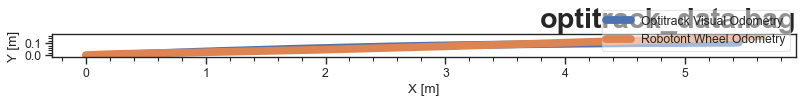


Saved figure as: traj_areaoptitrack_data.bag.png


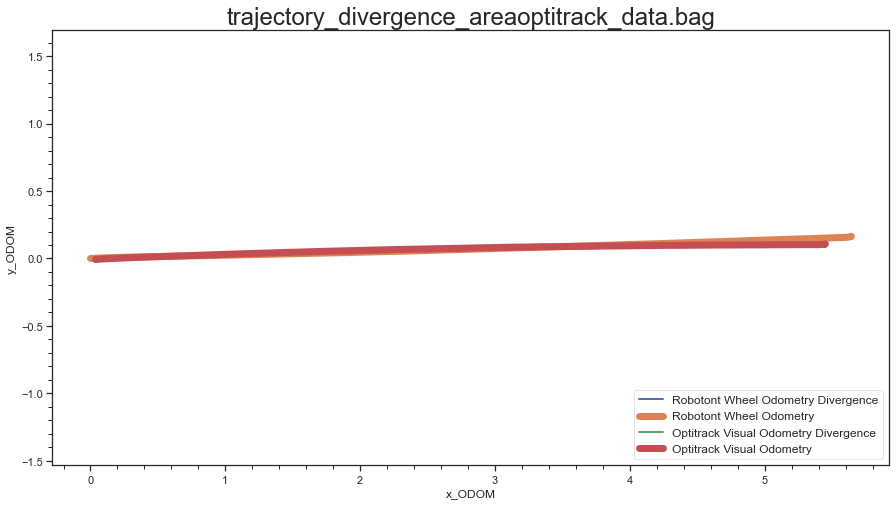

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:697: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Saved figure as: vector_heading_traj_sliced_0_to_-1optitrack_data.bag.png


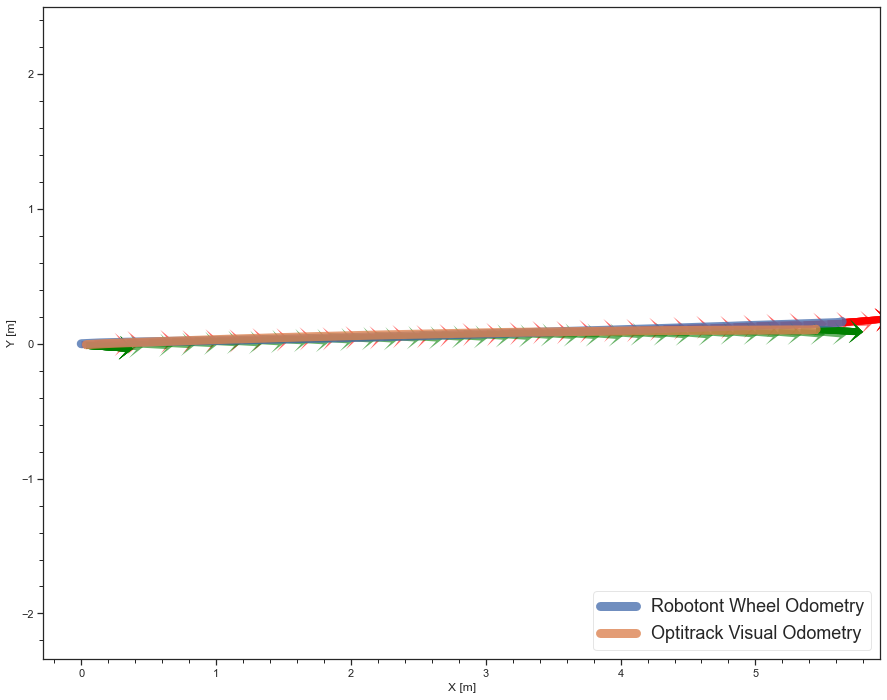


Analysis for file: optitrack_data.bag

The standard deviation of orientation values = 5.7831
The average MSE of orientation values = 33.44447522341345

The average MSE of x values = 7.659231557048553
The average MSE of y values = 0.0025465290359704806

The standard deviation of x values = 2.7675
The standard deviation of y values =  0.0505

Ground truth assumed calibrated up to digit 4

Therefore any measurement = measured value ± standard deviation [unit]

Therefore any measurement = X ± 2.7675 [m]

Therefore any measurement = Y ± 0.0505 [m]

Therefore any measurement = O ± 5.7831 [deg]

Saved figure as: traj_divergence0_to_-1optitrack_data.bag.png


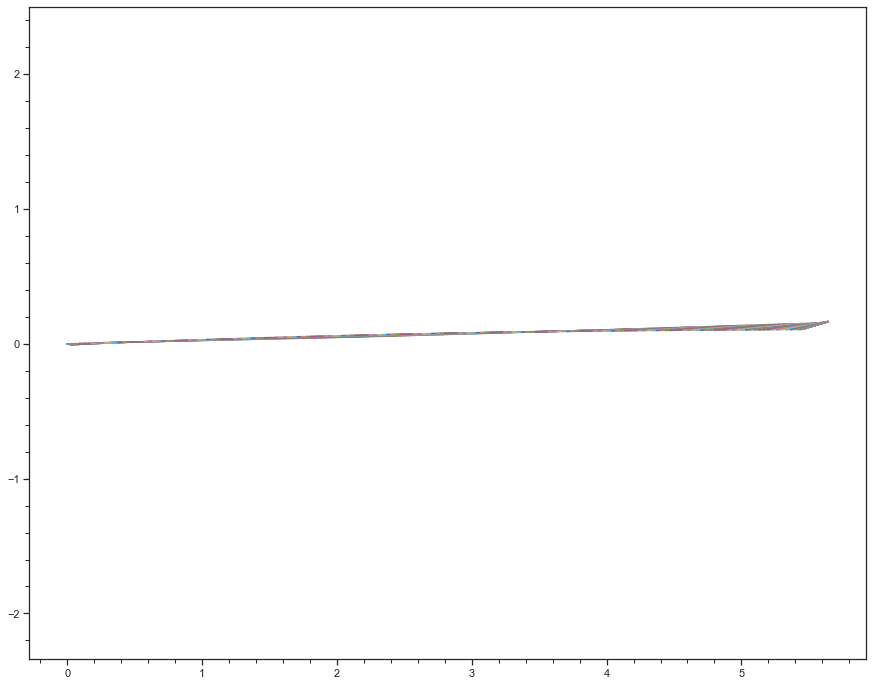

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:697: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Saved figure as: heading_traj_sliced_maneuever_errors0_to_-1optitrack_data.bag.png


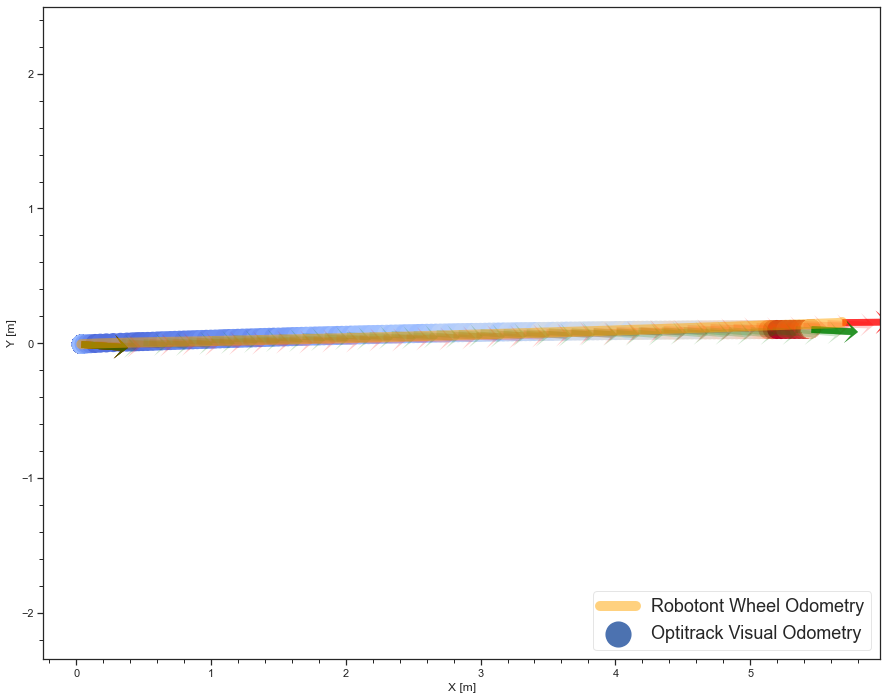

[INFO]  Data folder optitrack_data_ca2m_laminate_stock already exists. Not creating.

Stored the following csv files from all bag topics:
['optitrack_data_ca2m_laminate_stock/odom.csv', 'optitrack_data_ca2m_laminate_stock/vrpn_client_node-robotont-pose.csv']

Stored: Odometry Data	And: Optitrack Data


<ipython-input-908-858b505f70ac>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ODOM['Orientation_ODOM'] = Z_od # add odometry orientation data column
<ipython-input-908-858b505f70ac>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _OPTI['Orientation_OPTI'] = Z_op # add optitrack orientation data column
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati


Saved figure as: basic_traj_from_odom0_to_-1optitrack_data_ca2m_laminate_stock.bag.png


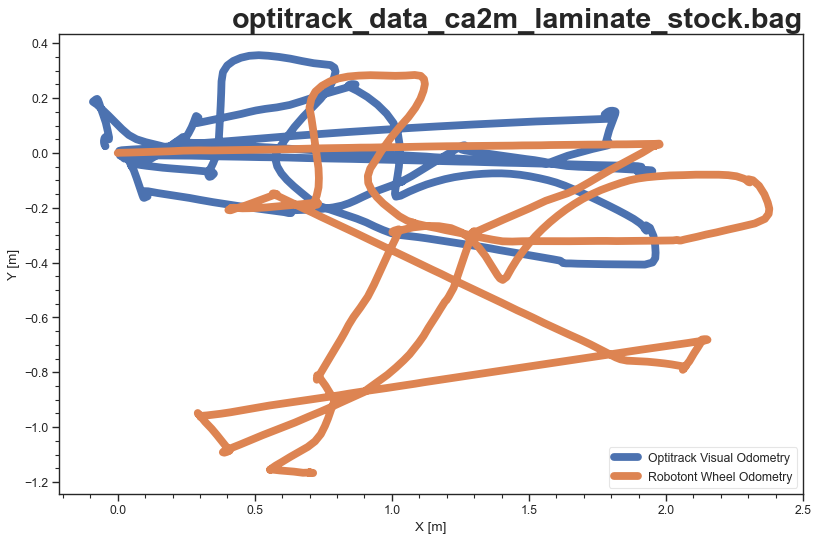


Saved figure as: traj_areaoptitrack_data_ca2m_laminate_stock.bag.png


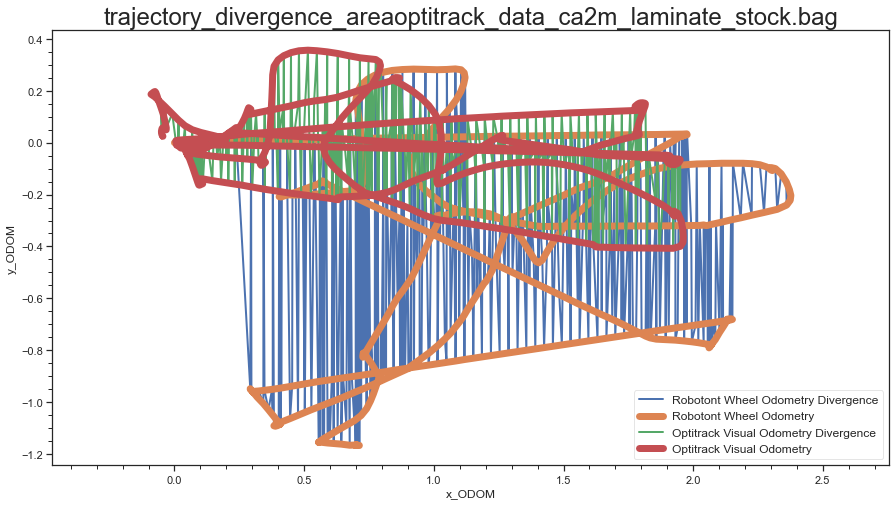

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:697: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Saved figure as: vector_heading_traj_sliced_0_to_-1optitrack_data_ca2m_laminate_stock.bag.png


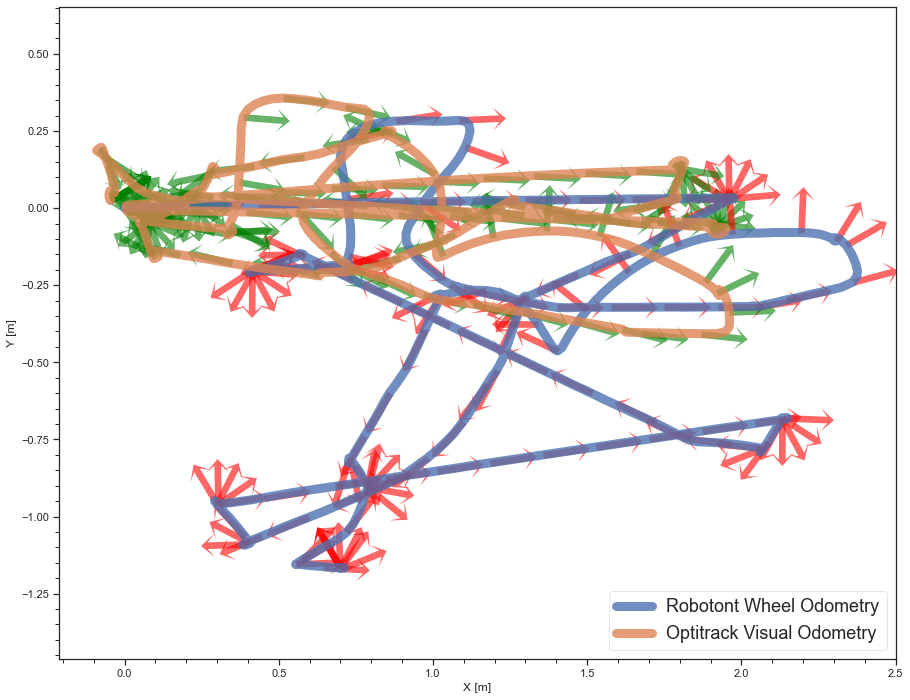


Analysis for file: optitrack_data_ca2m_laminate_stock.bag

The standard deviation of orientation values = 118.6232
The average MSE of orientation values = 14071.460916845852

The average MSE of x values = 0.7584891064449253
The average MSE of y values = 0.37188630369462916

The standard deviation of x values = 0.8709
The standard deviation of y values =  0.6098

Ground truth assumed calibrated up to digit 4

Therefore any measurement = measured value ± standard deviation [unit]

Therefore any measurement = X ± 0.8709 [m]

Therefore any measurement = Y ± 0.6098 [m]

Therefore any measurement = O ± 118.6232 [deg]

Saved figure as: traj_divergence0_to_-1optitrack_data_ca2m_laminate_stock.bag.png


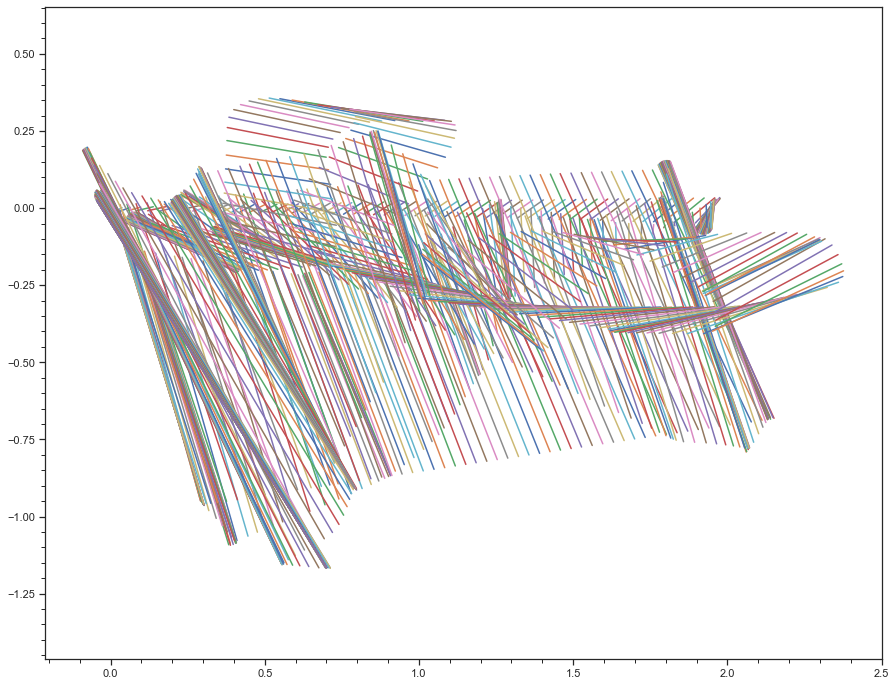

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:697: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Saved figure as: heading_traj_sliced_maneuever_errors0_to_-1optitrack_data_ca2m_laminate_stock.bag.png


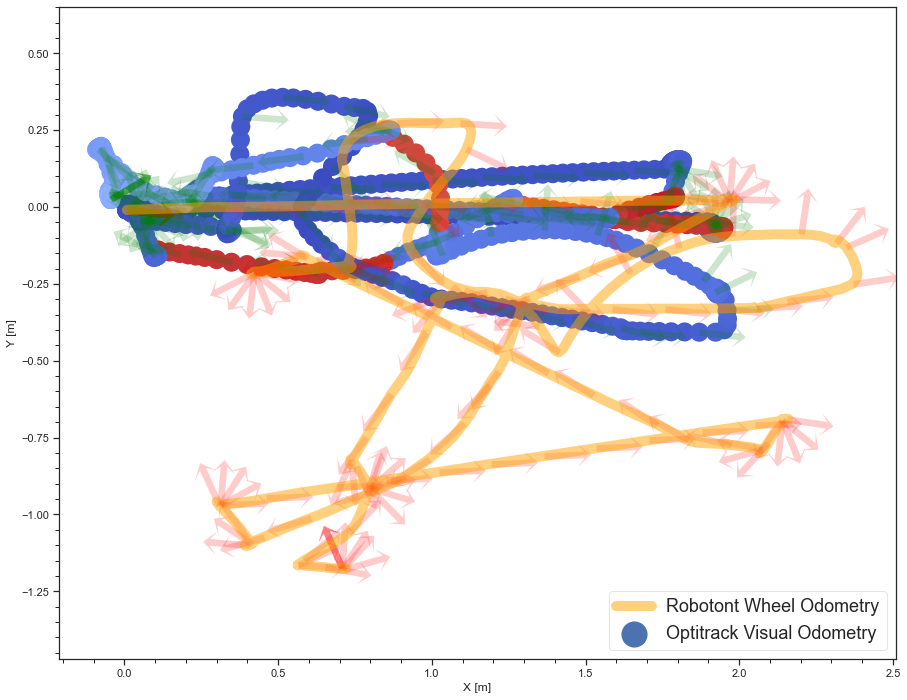

[INFO]  Data folder optitrack_data_cagame_field_low_pile_carpet_line_follow already exists. Not creating.

Stored the following csv files from all bag topics:
['optitrack_data_cagame_field_low_pile_carpet_line_follow/odom.csv', 'optitrack_data_cagame_field_low_pile_carpet_line_follow/vrpn_client_node-robotont-pose.csv']

Stored: Odometry Data	And: Optitrack Data


<ipython-input-908-858b505f70ac>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ODOM['Orientation_ODOM'] = Z_od # add odometry orientation data column
<ipython-input-908-858b505f70ac>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _OPTI['Orientation_OPTI'] = Z_op # add optitrack orientation data column
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati


Saved figure as: basic_traj_from_odom0_to_-1optitrack_data_cagame_field_low_pile_carpet_line_follow.bag.png


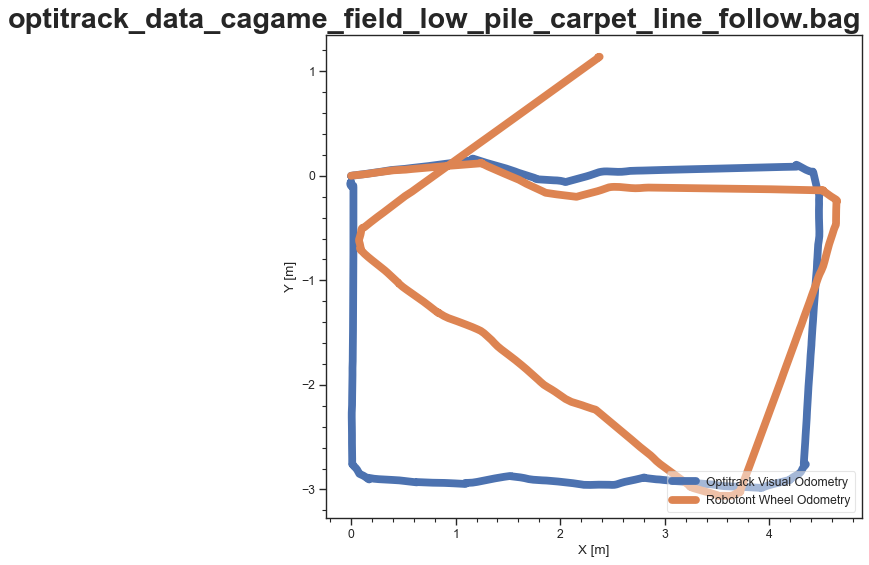


Saved figure as: traj_areaoptitrack_data_cagame_field_low_pile_carpet_line_follow.bag.png


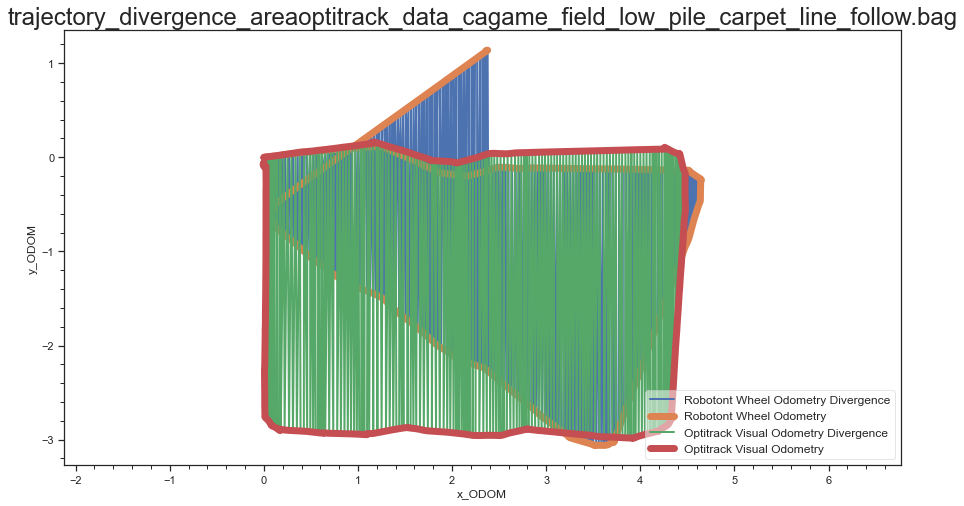

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))



Saved figure as: vector_heading_traj_sliced_0_to_-1optitrack_data_cagame_field_low_pile_carpet_line_follow.bag.png


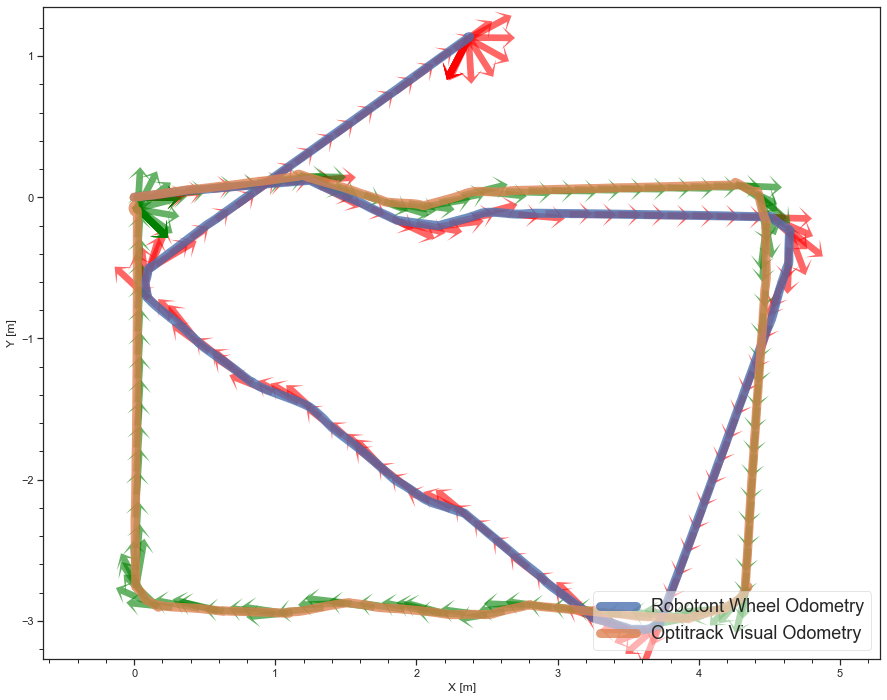


Analysis for file: optitrack_data_cagame_field_low_pile_carpet_line_follow.bag

The standard deviation of orientation values = 143.0066
The average MSE of orientation values = 20450.882087173417

The average MSE of x values = 6.407944242043767
The average MSE of y values = 6.853855726408642

The standard deviation of x values = 2.5314
The standard deviation of y values =  2.618

Ground truth assumed calibrated up to digit 4

Therefore any measurement = measured value ± standard deviation [unit]

Therefore any measurement = X ± 2.5314 [m]

Therefore any measurement = Y ± 2.618 [m]

Therefore any measurement = O ± 143.0066 [deg]

Saved figure as: traj_divergence0_to_-1optitrack_data_cagame_field_low_pile_carpet_line_follow.bag.png


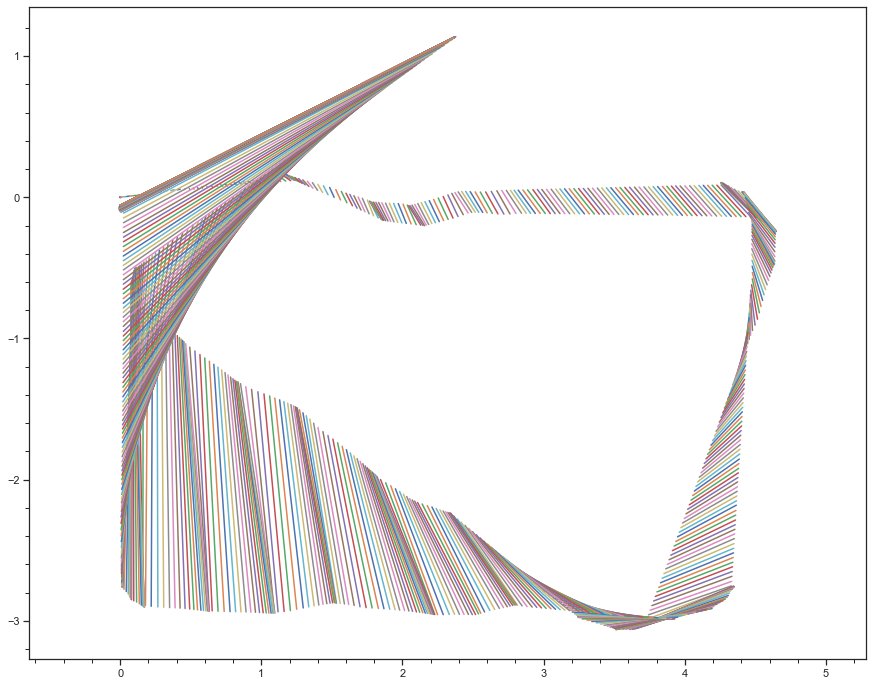

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))



Saved figure as: heading_traj_sliced_maneuever_errors0_to_-1optitrack_data_cagame_field_low_pile_carpet_line_follow.bag.png


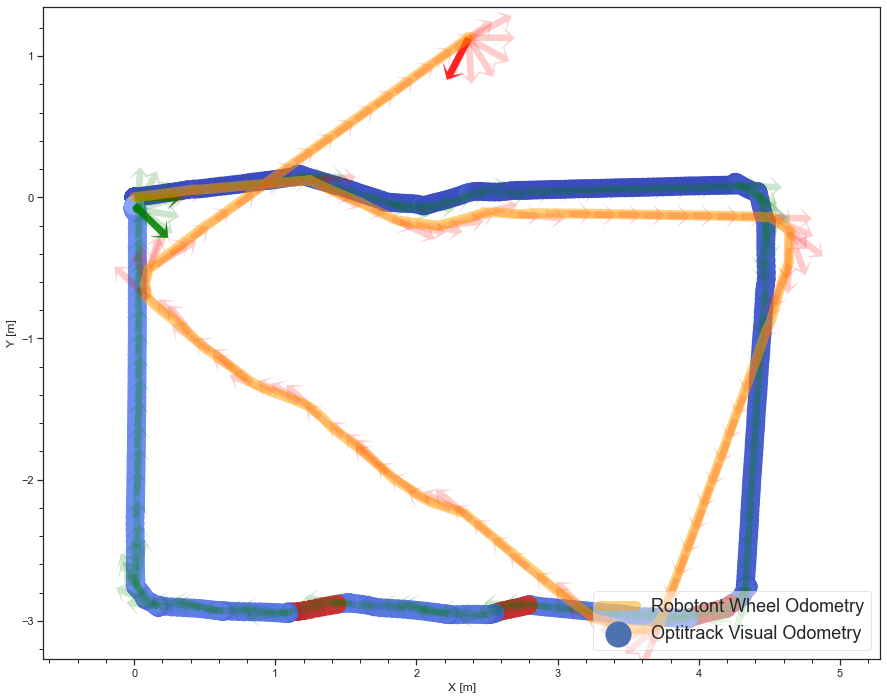

[INFO]  Data folder optitrack_data_caplayground already exists. Not creating.

Stored the following csv files from all bag topics:
['optitrack_data_caplayground/odom.csv', 'optitrack_data_caplayground/vrpn_client_node-robotont-pose.csv']

Stored: Odometry Data	And: Optitrack Data


<ipython-input-908-858b505f70ac>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ODOM['Orientation_ODOM'] = Z_od # add odometry orientation data column
<ipython-input-908-858b505f70ac>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _OPTI['Orientation_OPTI'] = Z_op # add optitrack orientation data column
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati


Saved figure as: basic_traj_from_odom0_to_-1optitrack_data_caplayground.bag.png


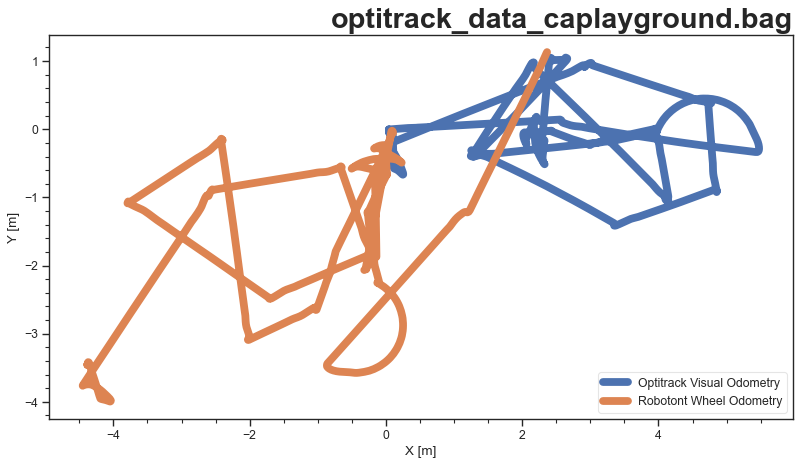


Saved figure as: traj_areaoptitrack_data_caplayground.bag.png


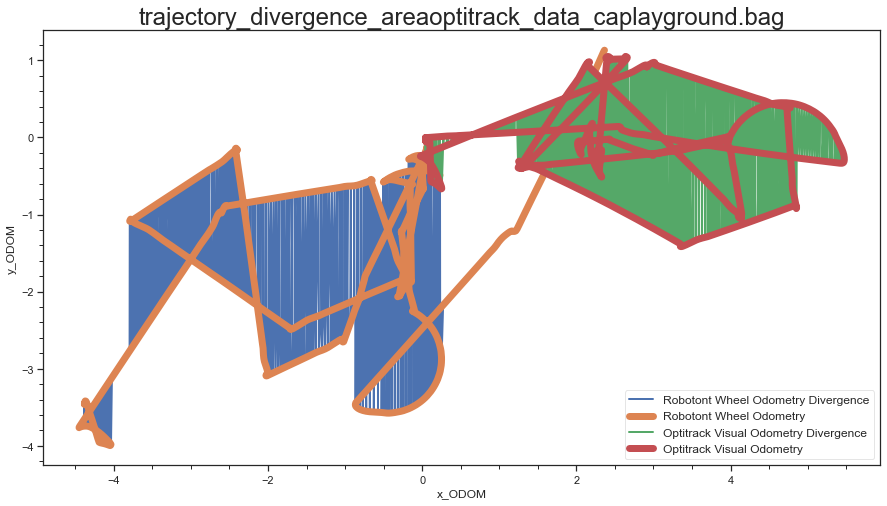


Saved figure as: vector_heading_traj_sliced_0_to_-1optitrack_data_caplayground.bag.png


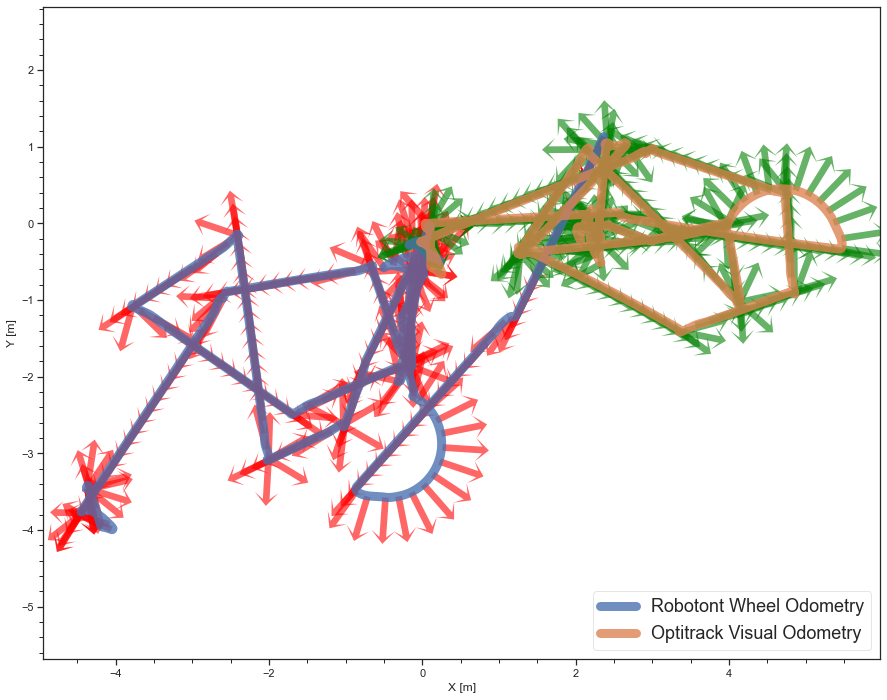


Analysis for file: optitrack_data_caplayground.bag

The standard deviation of orientation values = 172.2421
The average MSE of orientation values = 29667.35789010813

The average MSE of x values = 3.9347763460509375
The average MSE of y values = 3.856503480421717

The standard deviation of x values = 1.9836
The standard deviation of y values =  1.9638

Ground truth assumed calibrated up to digit 4

Therefore any measurement = measured value ± standard deviation [unit]

Therefore any measurement = X ± 1.9836 [m]

Therefore any measurement = Y ± 1.9638 [m]

Therefore any measurement = O ± 172.2421 [deg]

Saved figure as: traj_divergence0_to_-1optitrack_data_caplayground.bag.png


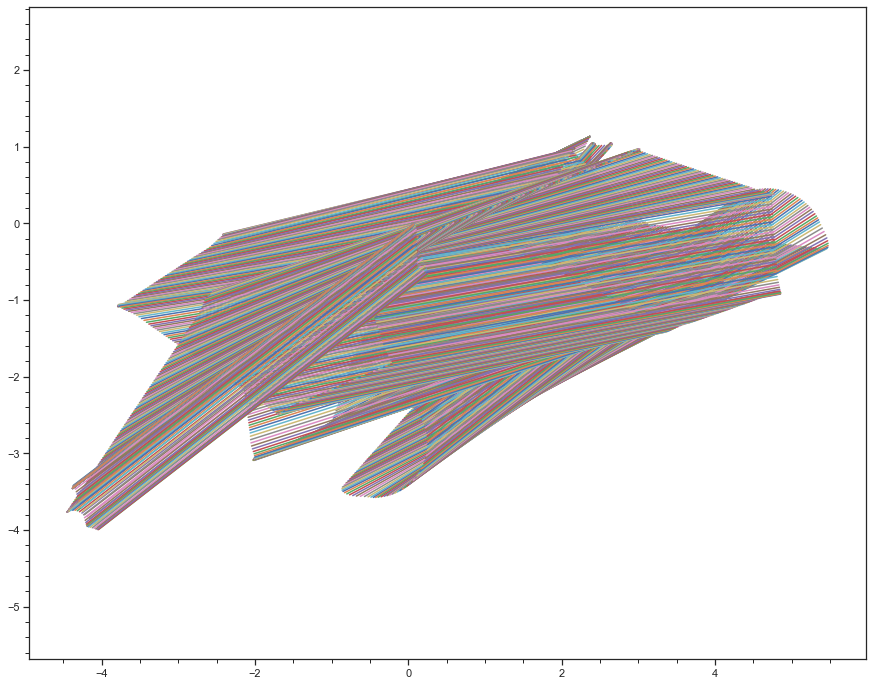


Saved figure as: heading_traj_sliced_maneuever_errors0_to_-1optitrack_data_caplayground.bag.png


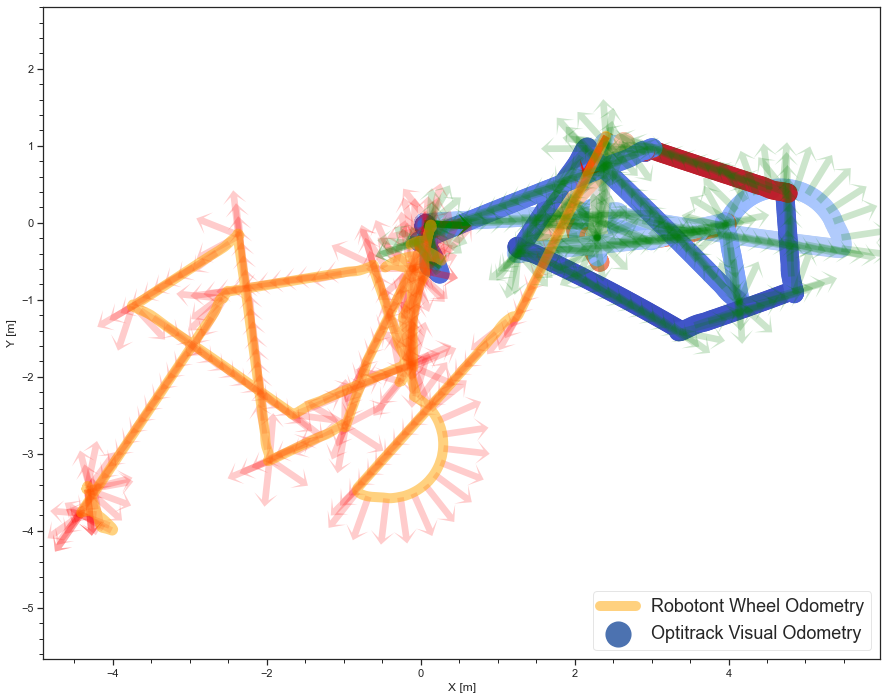

[INFO]  Data folder optitrack_data_cardboard_substrate already exists. Not creating.

Stored the following csv files from all bag topics:
['optitrack_data_cardboard_substrate/odom.csv', 'optitrack_data_cardboard_substrate/vrpn_client_node-robotont-pose.csv']

Stored: Odometry Data	And: Optitrack Data


<ipython-input-908-858b505f70ac>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ODOM['Orientation_ODOM'] = Z_od # add odometry orientation data column
<ipython-input-908-858b505f70ac>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _OPTI['Orientation_OPTI'] = Z_op # add optitrack orientation data column
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati


Saved figure as: basic_traj_from_odom0_to_-1optitrack_data_cardboard_substrate.bag.png


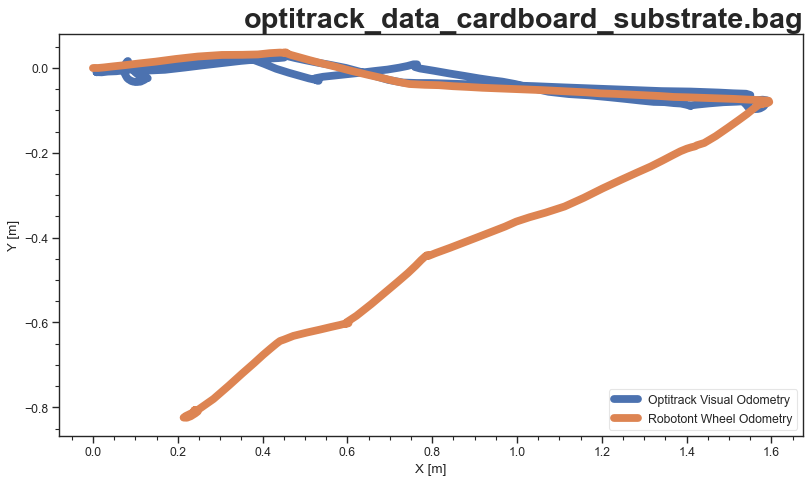


Saved figure as: traj_areaoptitrack_data_cardboard_substrate.bag.png


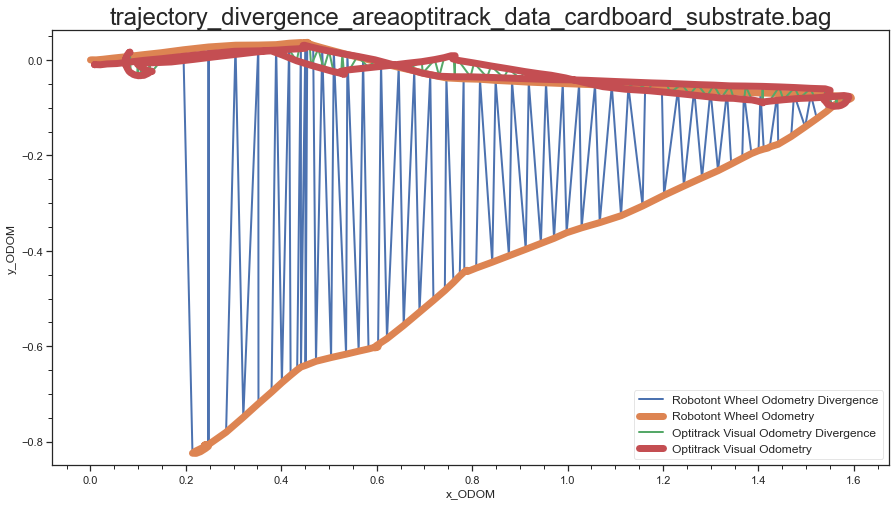

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))



Saved figure as: vector_heading_traj_sliced_0_to_-1optitrack_data_cardboard_substrate.bag.png


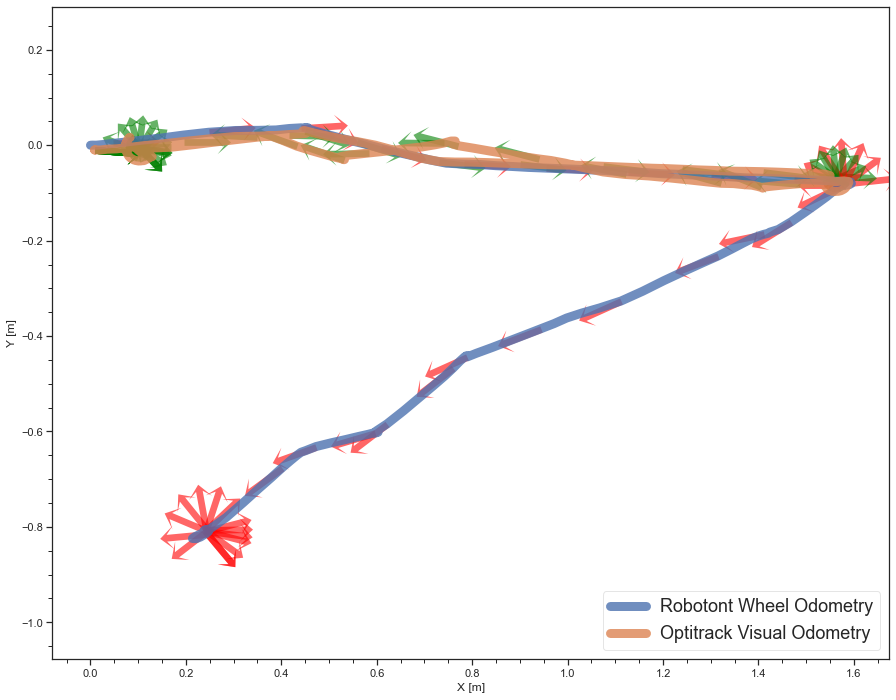


Analysis for file: optitrack_data_cardboard_substrate.bag

The standard deviation of orientation values = 90.9716
The average MSE of orientation values = 8275.831636062167

The average MSE of x values = 0.6197281556905957
The average MSE of y values = 0.21769759202698985

The standard deviation of x values = 0.7872
The standard deviation of y values =  0.4666

Ground truth assumed calibrated up to digit 4

Therefore any measurement = measured value ± standard deviation [unit]

Therefore any measurement = X ± 0.7872 [m]

Therefore any measurement = Y ± 0.4666 [m]

Therefore any measurement = O ± 90.9716 [deg]

Saved figure as: traj_divergence0_to_-1optitrack_data_cardboard_substrate.bag.png


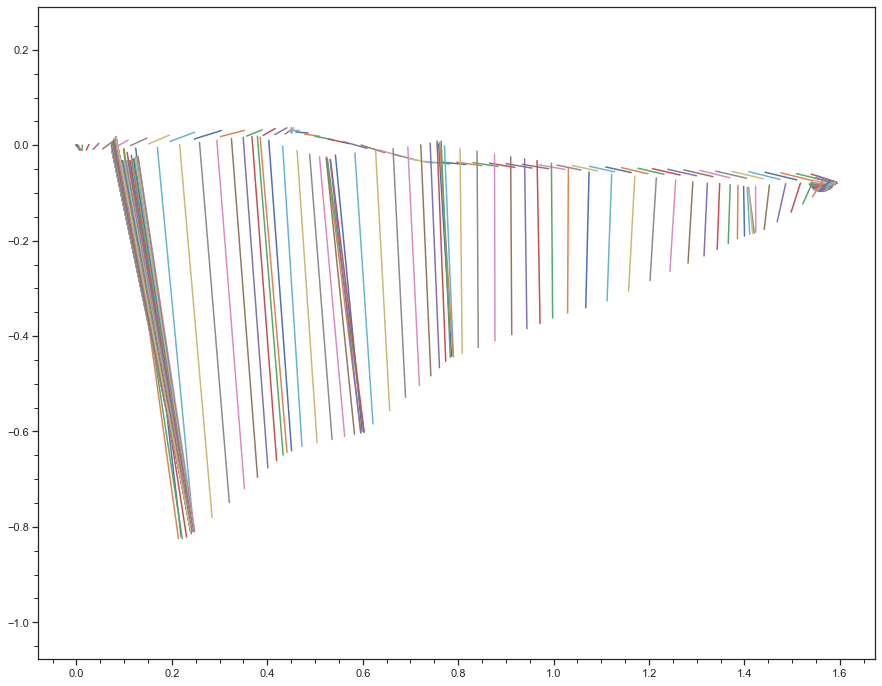


Saved figure as: heading_traj_sliced_maneuever_errors0_to_-1optitrack_data_cardboard_substrate.bag.png


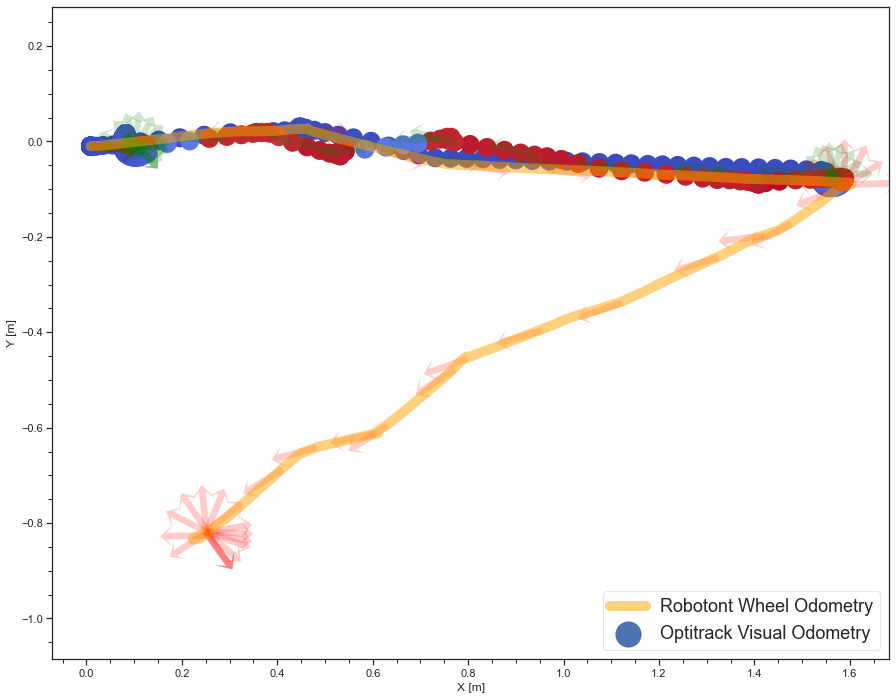

[INFO]  Data folder optitrack_data_cardboard_test already exists. Not creating.

Stored the following csv files from all bag topics:
['optitrack_data_cardboard_test/odom.csv', 'optitrack_data_cardboard_test/vrpn_client_node-robotont-pose.csv']

Stored: Odometry Data	And: Optitrack Data


<ipython-input-908-858b505f70ac>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ODOM['Orientation_ODOM'] = Z_od # add odometry orientation data column
<ipython-input-908-858b505f70ac>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _OPTI['Orientation_OPTI'] = Z_op # add optitrack orientation data column
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati


Saved figure as: basic_traj_from_odom0_to_-1optitrack_data_cardboard_test.bag.png


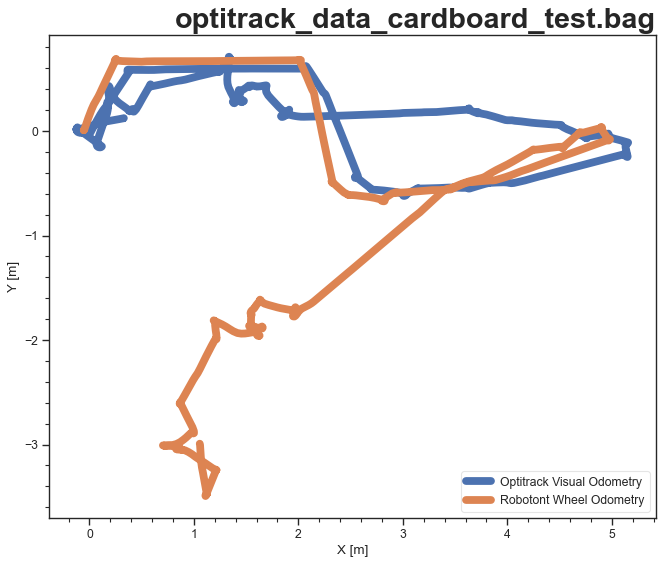


Saved figure as: traj_areaoptitrack_data_cardboard_test.bag.png


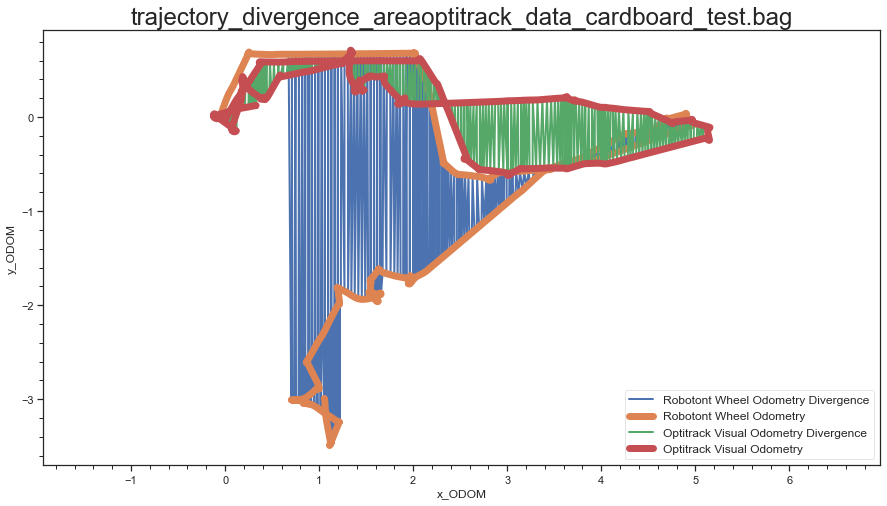

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:697: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Saved figure as: vector_heading_traj_sliced_0_to_-1optitrack_data_cardboard_test.bag.png


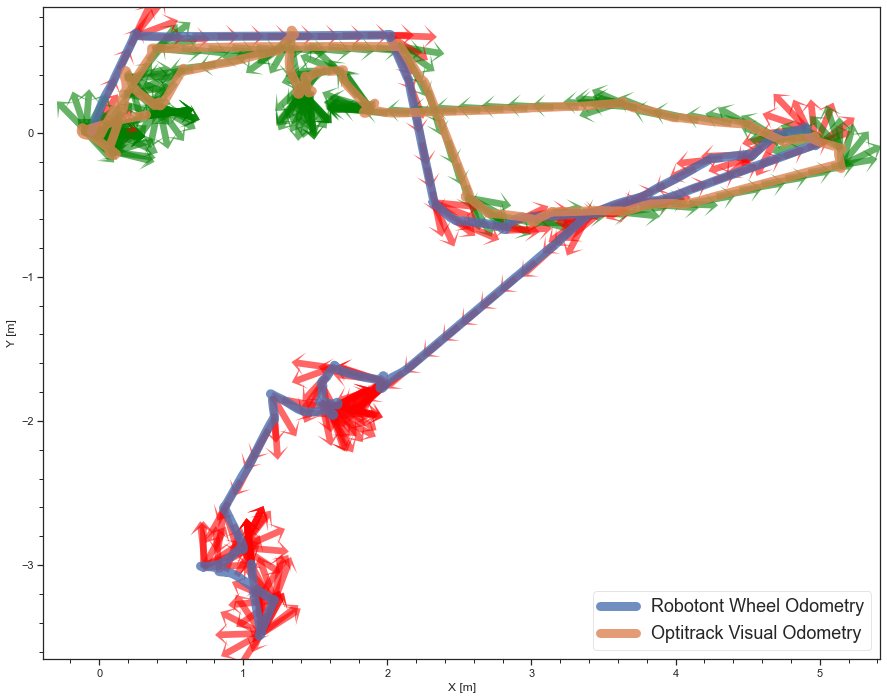


Analysis for file: optitrack_data_cardboard_test.bag

The standard deviation of orientation values = 119.1901
The average MSE of orientation values = 14206.287137865404

The average MSE of x values = 4.987694657715397
The average MSE of y values = 3.5628093236892893

The standard deviation of x values = 2.2333
The standard deviation of y values =  1.8875

Ground truth assumed calibrated up to digit 4

Therefore any measurement = measured value ± standard deviation [unit]

Therefore any measurement = X ± 2.2333 [m]

Therefore any measurement = Y ± 1.8875 [m]

Therefore any measurement = O ± 119.1901 [deg]

Saved figure as: traj_divergence0_to_-1optitrack_data_cardboard_test.bag.png


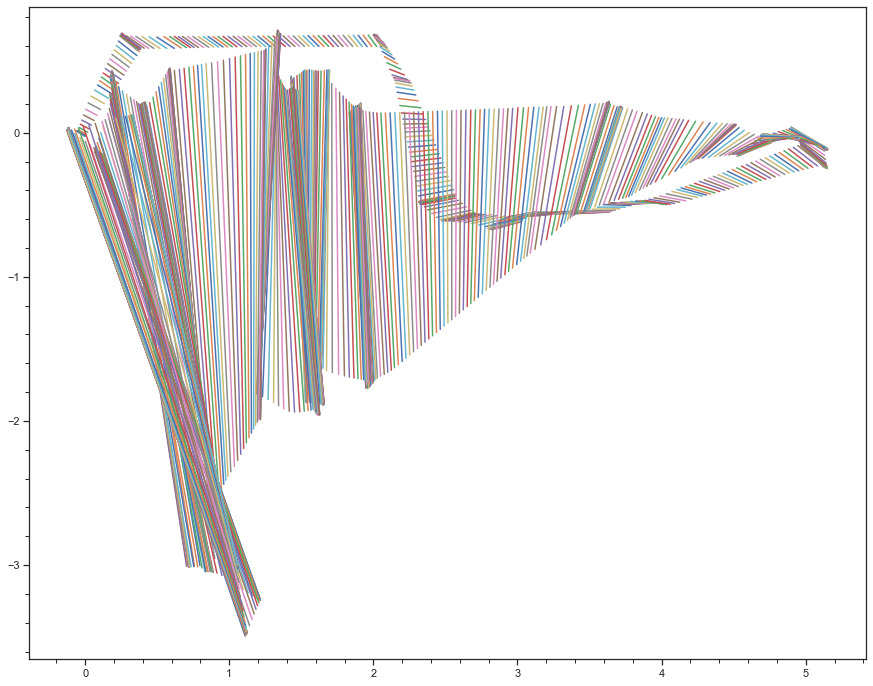

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:697: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Saved figure as: heading_traj_sliced_maneuever_errors0_to_-1optitrack_data_cardboard_test.bag.png


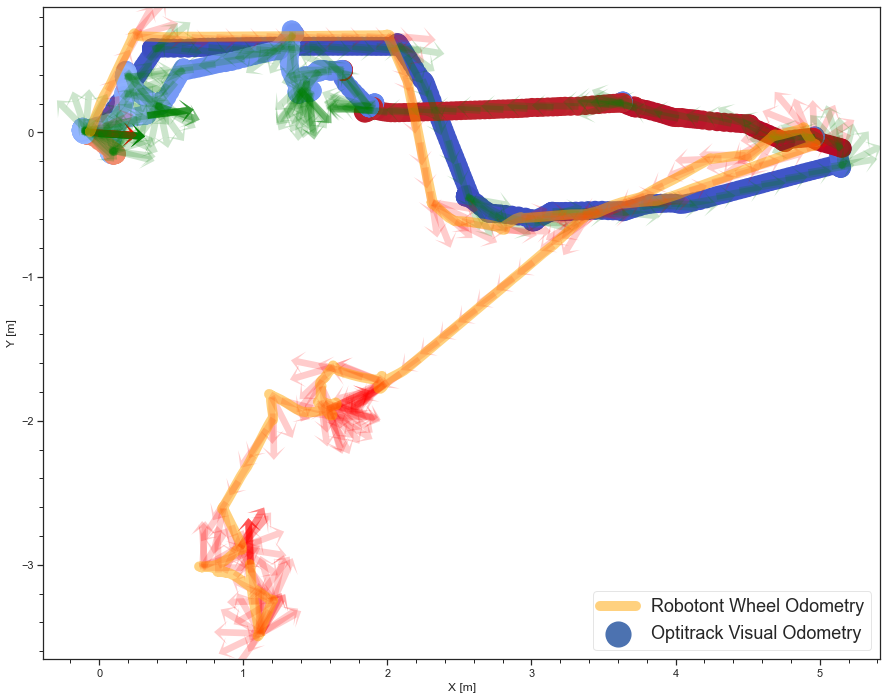

[INFO]  Data folder optitrack_data_playground_2 already exists. Not creating.

Stored the following csv files from all bag topics:
['optitrack_data_playground_2/odom.csv', 'optitrack_data_playground_2/vrpn_client_node-robotont-pose.csv']

Stored: Odometry Data	And: Optitrack Data


<ipython-input-908-858b505f70ac>:129: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _ODOM['Orientation_ODOM'] = Z_od # add odometry orientation data column
<ipython-input-908-858b505f70ac>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _OPTI['Orientation_OPTI'] = Z_op # add optitrack orientation data column
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati


Saved figure as: basic_traj_from_odom0_to_-1optitrack_data_playground_2.bag.png


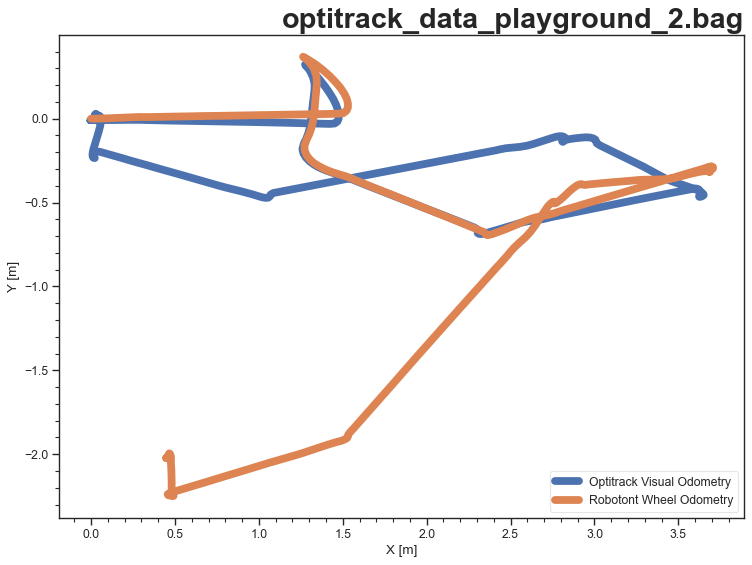


Saved figure as: traj_areaoptitrack_data_playground_2.bag.png


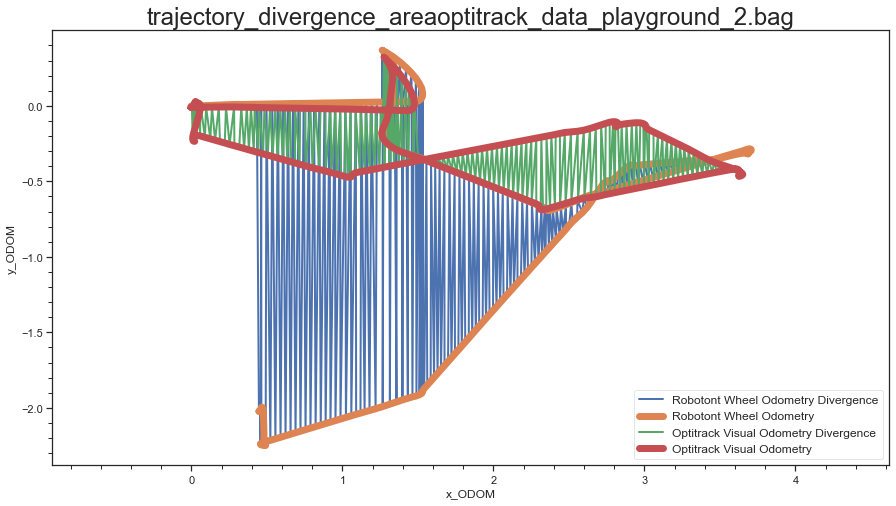

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\quiver.py:715: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))



Saved figure as: vector_heading_traj_sliced_0_to_-1optitrack_data_playground_2.bag.png


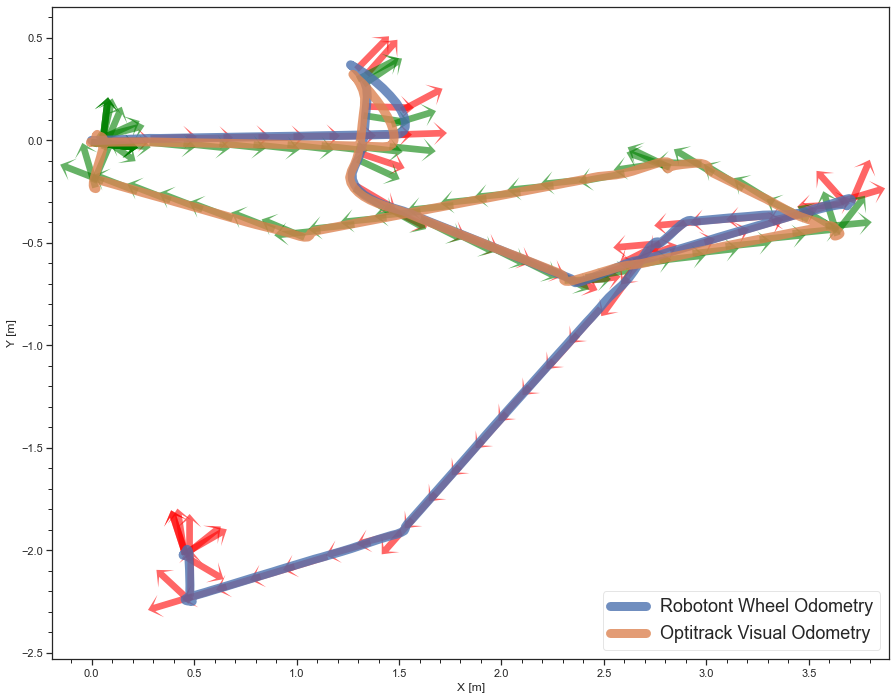


Analysis for file: optitrack_data_playground_2.bag

The standard deviation of orientation values = 111.7537
The average MSE of orientation values = 12488.884803360708

The average MSE of x values = 3.380639462012391
The average MSE of y values = 1.2765995074142864

The standard deviation of x values = 1.8387
The standard deviation of y values =  1.1299

Ground truth assumed calibrated up to digit 4

Therefore any measurement = measured value ± standard deviation [unit]

Therefore any measurement = X ± 1.8387 [m]

Therefore any measurement = Y ± 1.1299 [m]

Therefore any measurement = O ± 111.7537 [deg]

Saved figure as: traj_divergence0_to_-1optitrack_data_playground_2.bag.png


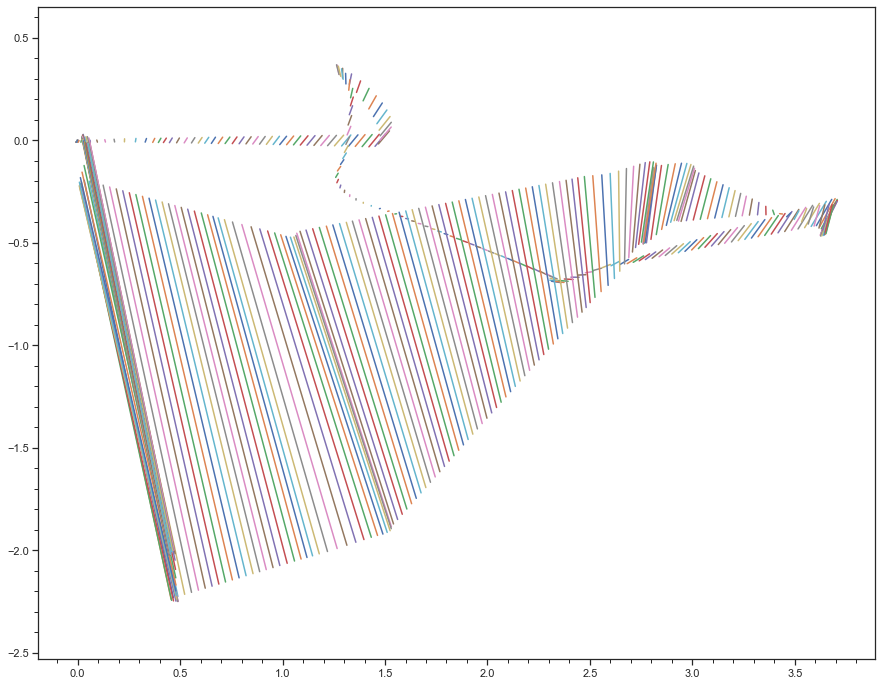


Saved figure as: heading_traj_sliced_maneuever_errors0_to_-1optitrack_data_playground_2.bag.png


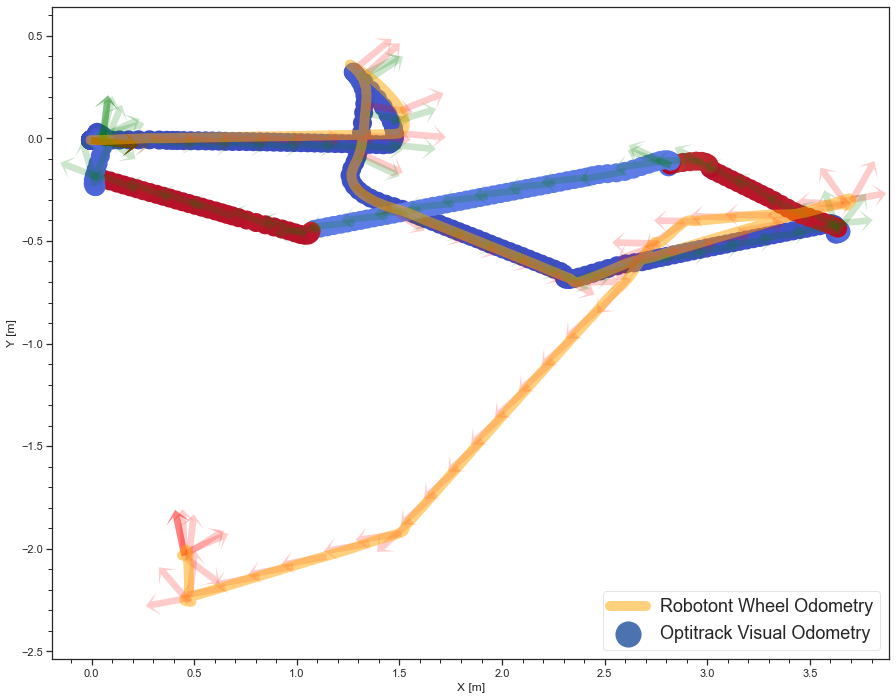


The overall average standard deviation for Translation X axis = 1.8589428571428572

The overall average standard deviation for Translation X axis = 1.2465857142857142

The overall average standard deviation for Orientation = 108.79577142857143


In [909]:
#basename_without_ext = os.path.splitext(os.path.basename(logbookpath))[0]

#files = [f for f in os.listdir('.') if os.path.isfile(f)]
#for f in files:
#    print(f)
#bagfiles = ['optitrack_data.bag', 
#            'optitrack_data_ca2m_laminate_stock.bag', 
#            'optitrack_data_cagame_field_low_pile_carpet_line_follow.bag',
#            'optitrack_data_caplayground.bag',
#            'optitrack_data_cardboard_substrate.bag',
#            'optitrack_data_cardboard_test.bag',
#            'optitrack_data_playground_2.bag']

bagfiles = ['optitrack_data.bag', 
            'optitrack_data_ca2m_laminate_stock.bag', 
            'optitrack_data_cagame_field_low_pile_carpet_line_follow.bag',
            'optitrack_data_caplayground.bag',
            'optitrack_data_cardboard_substrate.bag',
            'optitrack_data_cardboard_test.bag',
            'optitrack_data_playground_2.bag']
st_dev_x_s = []
st_dev_y_s = []
st_dev_o_s = []
for bagfile in bagfiles:
    st_dev_x, st_dev_y, st_dev_o = produce_report(bagfile, savefile=True)
    st_dev_x_s.append(st_dev_x)
    st_dev_y_s.append(st_dev_y)
    st_dev_o_s.append(st_dev_o)
#produce_report(bagfiles[-3], savefile=True)
print(f"\nThe overall average standard deviation for Translation X axis = {round(np.mean(st_dev_x_s), 4)}")
print(f"\nThe overall average standard deviation for Translation X axis = {round(np.mean(st_dev_y_s), 4)}")
print(f"\nThe overall average standard deviation for Orientation = {round(np.mean(st_dev_o_s), 4)}")

## optitrack calibrated to 0.2mm accuracy ==> can round till 4th digit

In [910]:
print(f"\nThe overall average standard deviation for Translation X axis = {round(np.mean(st_dev_x_s), 4)}")
print(f"\nThe overall average standard deviation for Translation X axis = {round(np.mean(st_dev_y_s), 4)}")
print(f"\nThe overall average standard deviation for Orientation = {round(np.mean(st_dev_o_s), 4)}")


The overall average standard deviation for Translation X axis = 1.8589

The overall average standard deviation for Translation X axis = 1.2466

The overall average standard deviation for Orientation = 108.7958


### **'Time_OPTI', 'x_OPTI', 'y_OPTI', 'Orientation_OPTI', 'Time_ODOM', 'x_ODOM', 'y_ODOM', 'Orientation_ODOM'**

### To calculate the standard deviation of those numbers:
1. Work out the Mean (the simple average of the numbers)
2. Then for each number: subtract the Mean and square the result.
3. Then work out the mean of those squared differences.
4. Take the square root of that and we are done!

take every 50 and every 200 odom and opti data points and comput the mean between them

then assign each datapoint an index

then the datasets are synced (?)

[Q to E](https://stackoverflow.com/questions/56207448/efficient-quaternions-to-euler-transformation)

[matplotlib quiver](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.quiver.html)

[quiver & stream plot examples](https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.15-Quiver-and-Stream-Plots/)

In [690]:
%matplotlib inline

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
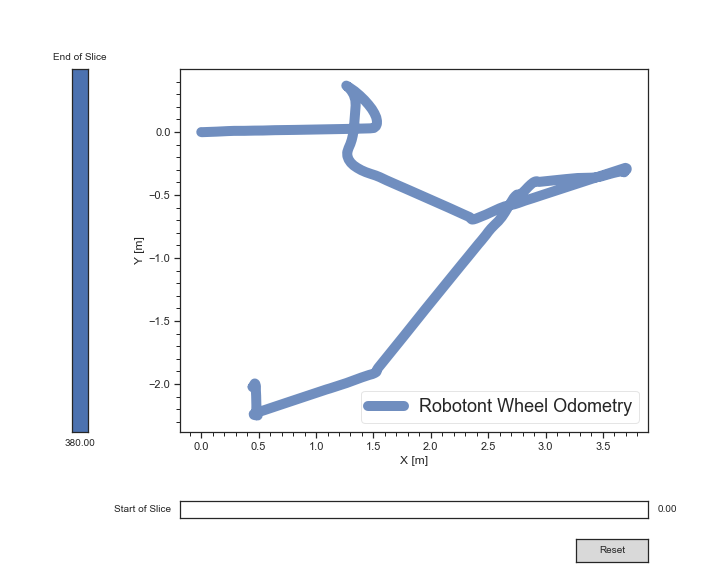

In [693]:
%matplotlib widget

# Define initial parameters
init_slice_start = 0
init_slice_end = len(odometry_df)

# The parametrized function to be plotted
def f(slice_start, slice_end):
    xd = odometry_df["x_ODOM"].iloc[slice_start:slice_end]
    yd = odometry_df["y_ODOM"].iloc[slice_start:slice_end]
    xp = odometry_df["x_OPTI"].iloc[slice_start:slice_end]
    yp = odometry_df["y_OPTI"].iloc[slice_start:slice_end]
    val_return = [xd, yd, xp, yp]
    return val_return

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()

plt.gcf().set_size_inches(10, 8)

line1, = plt.plot(f(init_slice_start, init_slice_end)[0], 
                 f(init_slice_start, init_slice_end)[1], 
                 label ='Robotont Wheel Odometry', 
                 linewidth=10, alpha=0.8)
'''
line2, = plt.plot(f(init_slice_start, init_slice_end)[2], 
                 f(init_slice_start, init_slice_end)[3], 
                 label ='Optitrack Visual Odometry', 
                 linewidth=10, alpha=0.8)
'''
# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
ax_slice_start = plt.axes([0.25, 0.1, 0.65, 0.03])

slice_start_slider = Slider(
    ax=ax_slice_start,
    label='Start of Slice',
    valmin=0,
    valmax=len(odometry_df),
    valinit=init_slice_start,
)

# Make a vertically oriented slider to control the amplitude
ax_slice_end = plt.axes([0.1, 0.25, 0.0225, 0.63])

slice_end_slider = Slider(
    ax=ax_slice_end,
    label="End of Slice",
    valmin=0,
    valmax=len(odometry_df),
    valinit=init_slice_end,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line1.set_xdata(f(slice_start_slider.val, slice_end_slider.val))
    line1.set_ydata(f(slice_start_slider.val, slice_end_slider.val))

    #line2.set_xdata(f(slice_start_slider.val, slice_end_slider.val))
    #line2.set_ydata(f(slice_start_slider.val, slice_end_slider.val))
    
    fig.canvas.draw_idle()


# register the update function with each slider
slice_start_slider.on_changed(update)
slice_end_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')

def reset(event):
    slice_start_slider.reset()
    slice_end_slider.reset()

button.on_clicked(reset)


#plt.legend(loc ="lower right", fontsize=18)

#plt.axis('equal')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.legend(loc ="lower right", fontsize=18)
plt.show()

In [ ]:
# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)

ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)



# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])

freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = plt.axes([0.1, 0.25, 0.0225, 0.63])

amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

[matplotlib slider demo](https://matplotlib.org/stable/gallery/widgets/slider_demo.html)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
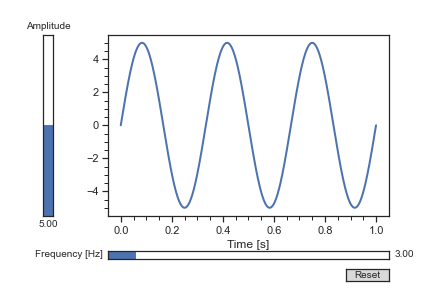

In [682]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
%matplotlib widget

# The parametrized function to be plotted
def f(t, amplitude, frequency):
    return amplitude * np.sin(2 * np.pi * frequency * t)

t = np.linspace(0, 1, 1000)

# Define initial parameters
init_amplitude = 5
init_frequency = 3

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots()
line, = plt.plot(t, f(t, init_amplitude, init_frequency), lw=2)
ax.set_xlabel('Time [s]')

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03])

freq_slider = Slider(
    ax=axfreq,
    label='Frequency [Hz]',
    valmin=0.1,
    valmax=30,
    valinit=init_frequency,
)

# Make a vertically oriented slider to control the amplitude
axamp = plt.axes([0.1, 0.25, 0.0225, 0.63])

amp_slider = Slider(
    ax=axamp,
    label="Amplitude",
    valmin=0,
    valmax=10,
    valinit=init_amplitude,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    line.set_ydata(f(t, amp_slider.val, freq_slider.val))
    fig.canvas.draw_idle()


# register the update function with each slider
freq_slider.on_changed(update)
amp_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')


def reset(event):
    freq_slider.reset()
    amp_slider.reset()
button.on_clicked(reset)

plt.show()

In [727]:
%matplotlib inline